In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Consts

METRIC_TYPES = ["l1", "l2"]
FEATURE_TYPES = ["score", "rank", "log_rank"]

build_cmd_template = (
    "./RPG --mode base --baseSize 1000000 --trainQueries 1000 "
    "--base data/{dataset}/data/model_scores/scores_train.bin "
    "--outputGraph {graphPath} "
    "--relevanceVector {relevanceVector} --efConstruction {efConstruction} --M 8"
)

search_cmd_template = (
    "./RPG --mode query --baseSize 1000000 --querySize 1000"
    " --query data/{dataset}/data/model_scores/scores_test.bin --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK 5 --output data/{dataset}/result.txt --gtQueries 1000 --gtTop 100 "
    "--groundtruth data/{dataset}/data/model_scores/groundtruth.bin"
)

In [3]:
# exp config

dataset = "video"
efConstruction = 1000
relevanceVector = 100 # length of relevance vector
efSearchTicks = list(np.exp(np.linspace(np.log(10), np.log(5000), 57)).astype("int"))


In [4]:
def measure_performance(graph, dataset, ef_ticks):
    relevances = []
    recalls = []
    times = []
    model_evals = []
    for ef in ef_ticks:
        cmd = search_cmd_template.format(inputGraph=graph, dataset=dataset, efSearch=ef)
        with os.popen(cmd) as out:
            for line in out:
                for arr, prefix, suff_len in [
                    (relevances, "Average relevance: ", 1),
                    (recalls, "Recall@5: ", 1),
                    (times, "Average query time: ", 3),
                    (model_evals, "Average number of model computations: ", 1)
                ]:
                    if line.startswith(prefix):
                        arr.append(float(line[len(prefix):-suff_len]))
    return {
        "relevance": relevances,
        "recall": recalls,
        "time": times,
        "evals": model_evals
    }

In [5]:
# build graphs
for metric_type in METRIC_TYPES:
    for feature_type in FEATURE_TYPES:
        # build graph
        graph_path = "data/{}/{}_{}_graph_rel{}ef{}.out".format(
            dataset, metric_type, feature_type,
            relevanceVector, efConstruction
        )
        build_cmd = build_cmd_template.format(
            graphPath=graph_path,
            dataset=dataset,
            efConstruction=efConstruction,
            relevanceVector=relevanceVector
        )
        print(build_cmd)
        os.system(build_cmd)
        print("Graph for {} metric and {} features is built".format(metric_type, feature_type))
        print()
        
#         graph_label = metric_type + " " + feature_type
#         results[graph_label] = measure_performance(graph_path, dataset, efSearchTicks)

./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/video/data/model_scores/scores_train.bin --outputGraph data/video/l1_score_graph_rel100ef1000.out --relevanceVector 100 --efConstruction 1000 --M 8
Graph for l1 metric and score features is built

./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/video/data/model_scores/scores_train.bin --outputGraph data/video/l1_rank_graph_rel100ef1000.out --relevanceVector 100 --efConstruction 1000 --M 8
Graph for l1 metric and rank features is built

./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/video/data/model_scores/scores_train.bin --outputGraph data/video/l1_log_rank_graph_rel100ef1000.out --relevanceVector 100 --efConstruction 1000 --M 8
Graph for l1 metric and log_rank features is built

./RPG --mode base --baseSize 1000000 --trainQueries 1000 --base data/video/data/model_scores/scores_train.bin --outputGraph data/video/l2_score_graph_rel100ef1000.out --relevanceVector 100 --efConst

In [6]:
# measure performance of graphs
results = {}
for metric_type in METRIC_TYPES:
    for feature_type in FEATURE_TYPES:
        # build graph
        graph_path = "data/{}/{}_{}_graph_rel{}ef{}.out".format(
            dataset, metric_type, feature_type,
            relevanceVector, efConstruction
        )
        graph_label = metric_type + " " + feature_type
        results[graph_label] = measure_performance(graph_path, dataset, efSearchTicks)

In [22]:
def plot_results(results, x_data="evals", y_data="recall"):
    plt.xlabel(x_data)
    plt.ylabel(y_data)
#     plt.xlim([3000, 20000])
#     plt.ylim([0.6, 1])
    plt.xscale('log')
    for label, stats in results.items():
        plt.plot(stats[x_data], stats[y_data], label=label)
        plt.scatter(stats[x_data], stats[y_data], s=10)
    plt.legend()
    plt.show()

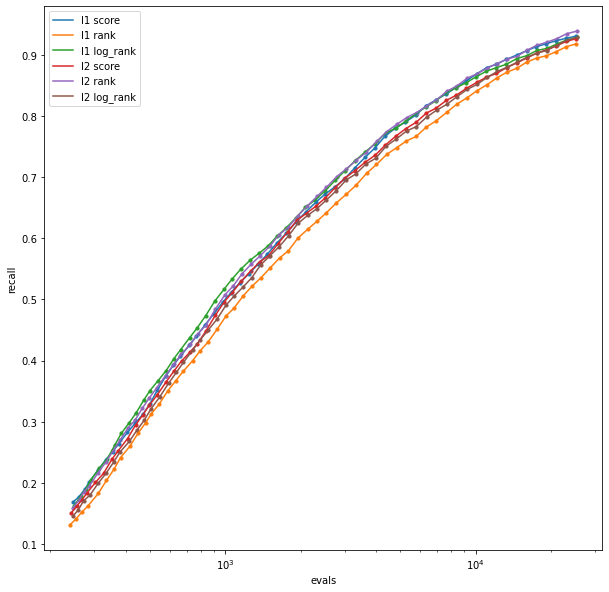

In [23]:
plt.figure(figsize=(10, 10))
plot_results(results)

In [9]:
results

{'l1 score': {'relevance': [8.09708,
   8.15324,
   8.22782,
   8.25777,
   8.32445,
   8.39914,
   8.46135,
   8.49866,
   8.56035,
   8.62685,
   8.69529,
   8.74086,
   8.78845,
   8.83147,
   8.86119,
   8.89255,
   8.91253,
   8.9437,
   8.9747,
   9.00635,
   9.0371,
   9.06041,
   9.08533,
   9.10708,
   9.12805,
   9.15196,
   9.18052,
   9.20377,
   9.22933,
   9.25141,
   9.27069,
   9.28564,
   9.30468,
   9.31499,
   9.3353,
   9.36206,
   9.37608,
   9.39205,
   9.40298,
   9.4127,
   9.42382,
   9.43962,
   9.45254,
   9.46893,
   9.485,
   9.49545,
   9.51059,
   9.51776,
   9.52046,
   9.52784,
   9.53287,
   9.53956,
   9.54526,
   9.54874,
   9.55379,
   9.55745,
   9.56195],
  'recall': [0.1686,
   0.177,
   0.1904,
   0.2014,
   0.2206,
   0.238,
   0.2512,
   0.2642,
   0.2824,
   0.2978,
   0.3124,
   0.3282,
   0.3516,
   0.3746,
   0.3924,
   0.4072,
   0.425,
   0.4398,
   0.4588,
   0.476,
   0.4952,
   0.5106,
   0.5272,
   0.5422,
   0.5578,
   0.5744,
   0.